In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.multioutput import MultiOutputRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.early_stop import no_progress_loss
import xgboost as xgb
import shap
plt.style.use("ggplot")

c:\Users\LL331070\AppData\Local\anaconda3\envs\data_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
stable_features_en = pd.read_csv("../date/result_all/en_genes_stability_score.csv", index_col="Feature_Name")
stable_features_rf = pd.read_csv("../date/result_all/rf_genes_stability_score.csv", index_col="Feature_Name")

In [4]:
X_selected_en = stable_features_en.loc[stable_features_en["Stability_Score"] >= 0.8].index.to_list()
X_selected_rf = stable_features_rf.loc[stable_features_rf["Stability_Score"] >= 0.8].index.to_list()
X_selected_genes = list(set(X_selected_en) | set(X_selected_rf))
intersection_genes = list(set(X_selected_en) & set(X_selected_rf))
print(f"Number of selected genes from EN: {len(X_selected_en)}")
print(f"Number of selected genes from RF: {len(X_selected_rf)}")
print(f"Number of selected genes: {len(X_selected_genes)}")
print(f"Number of intersection genes: {len(intersection_genes)}")

Number of selected genes from EN: 226
Number of selected genes from RF: 94
Number of selected genes: 314
Number of intersection genes: 6


In [75]:
for gene in X_selected_genes:
    print(gene)

ENSG00000106484
ENSG00000196611
ENSG00000180660
ENSG00000145604
ENSG00000177675
ENSG00000182957
ENSG00000183914
ENSG00000204335
ENSG00000175556
ENSG00000029534
ENSG00000175294
ENSG00000157510
ENSG00000170477
ENSG00000158856
ENSG00000135476
ENSG00000189060
ENSG00000147231
ENSG00000113249
ENSG00000218416
ENSG00000171488
ENSG00000099139
ENSG00000136574
ENSG00000251493
ENSG00000133030
ENSG00000189369
ENSG00000177455
ENSG00000215298
ENSG00000144407
ENSG00000109906
ENSG00000130768
ENSG00000100342
ENSG00000249550
ENSG00000257653
ENSG00000118971
ENSG00000042062
ENSG00000180616
ENSG00000259952
ENSG00000204941
ENSG00000244239
ENSG00000259343
ENSG00000110680
ENSG00000169594
ENSG00000168453
ENSG00000145506
ENSG00000061273
ENSG00000135643
ENSG00000207418
ENSG00000064692
ENSG00000006210
ENSG00000259498
ENSG00000102755
ENSG00000140092
ENSG00000171401
ENSG00000224187
ENSG00000184719
ENSG00000152778
ENSG00000196358
ENSG00000122591
ENSG00000165507
ENSG00000205869
ENSG00000182916
ENSG00000164093
ENSG0000

In [5]:
X = pd.read_csv("../date/X_y/X_all_preprocess.csv", index_col=0)
X.shape

(513, 6931)

In [6]:
y = np.load("../date/X_y/y_all_preprocess.npy")

In [7]:
X_selected = X[X_selected_genes]
X_selected.shape

(513, 314)

Convert id

In [52]:
gene_info = pd.read_csv("../date/Info/gene_info.csv", index_col=0)
gene_info

,gene_name,gene_type
gene_id,,
ENSG00000000003,TSPAN6,protein_coding
ENSG00000000005,TNMD,protein_coding
ENSG00000000419,DPM1,protein_coding
ENSG00000000457,SCYL3,protein_coding
ENSG00000000460,C1orf112,protein_coding
...,...,...
ENSG00000288669,AC008763.4,protein_coding
ENSG00000288670,AL592295.6,lncRNA
ENSG00000288671,AC006486.3,protein_coding


In [ ]:
gene_list = []
for gene in X_selected.columns:
    if gene in gene_info.index:
        symb = gene_info.loc[gene, "gene_name"]
        gene_list.append(symb)
    else:
        print(f"Gene {gene} not found in gene_info.")

# Non finded genes will be replaced with ensembl ID

Gene ENSG00000215298 not found in gene_info.
Gene ENSG00000207418 not found in gene_info.
Gene ENSG00000133808 not found in gene_info.
Gene ENSG00000108753 not found in gene_info.
Gene ENSG00000152268 not found in gene_info.
Gene ENSG00000241978 not found in gene_info.
Gene ENSG00000271738 not found in gene_info.


### XGBoost

In [8]:
# Spazio iperparametri
space_xgb = {
    'n_estimators': hp.quniform('n_estimators', 100, 1200, 20),
    'max_depth': hp.quniform('max_depth', 3, 12, 1),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.3),
    'gamma': hp.uniform('gamma', 0.0, 5.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'subsample': hp.uniform('subsample', 0.2, 1.0),
    'min_child_weight': hp.quniform('min_child_weight', 1, 15, 1),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-8), np.log(10)),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-8), np.log(10))
}

def objective_xgb(params):
    params_int = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': params['learning_rate'],
        'gamma': params['gamma'],
        'colsample_bytree': params['colsample_bytree'],
        'subsample': params['subsample'],
        'min_child_weight': int(params['min_child_weight']),
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda']
    }
    base = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **params_int)
    model = MultiOutputRegressor(base)
    r2_scores = cross_val_score(model, X_train_sel, y_train_sel, cv=5, scoring='r2', n_jobs=-1)
    return {'loss': -np.mean(r2_scores), 'status': STATUS_OK}



In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

all_shap0 = []
all_shap1 = []
all_X_tests = []
performance_records = []
feature_names = X_selected.columns.tolist()

for fold_idx, (train_index, test_index) in enumerate(kf.split(X_selected)):
    # Split dati
    X_train_sel, X_test_sel = X_selected.iloc[train_index], X_selected.iloc[test_index]
    y_train_sel, y_test_sel = y[train_index], y[test_index]

    trials_xgb = Trials()
    best_params = fmin(
        fn=objective_xgb,
        space=space_xgb,
        algo=tpe.suggest,
        max_evals=100,
        trials=trials_xgb,
        early_stop_fn=no_progress_loss(30),
        rstate=np.random.default_rng(42)
    )

    params_final = {
        'n_estimators': int(best_params['n_estimators']),
        'max_depth': int(best_params['max_depth']),
        'learning_rate': best_params['learning_rate'],
        'gamma': best_params['gamma'],
        'colsample_bytree': best_params['colsample_bytree'],
        'subsample': best_params['subsample'],
        'min_child_weight': int(best_params['min_child_weight']),
        'reg_alpha': best_params['reg_alpha'],
        'reg_lambda': best_params['reg_lambda']
    }
    base_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **params_final)
    model = MultiOutputRegressor(base_model)
    model.fit(X_train_sel, y_train_sel)

    y_pred = model.predict(X_test_sel)
    performance_records.append({
        "fold": fold_idx + 1,
        "R2_Propensity": r2_score(y_test_sel[:, 0], y_pred[:, 0]),
        "R2_Intensity": r2_score(y_test_sel[:, 1], y_pred[:, 1]),
        "MSE_Propensity": mean_squared_error(y_test_sel[:, 0], y_pred[:, 0]),
        "MSE_Intensity": mean_squared_error(y_test_sel[:, 1], y_pred[:, 1])
    })

    print(f"Fold {fold_idx + 1} - R2 Propensity: {performance_records[-1]['R2_Propensity']:.4f}, "
          f"R2 Intensity: {performance_records[-1]['R2_Intensity']:.4f}, "
          f"MSE Propensity: {performance_records[-1]['MSE_Propensity']:.4f}, "
          f"MSE Intensity: {performance_records[-1]['MSE_Intensity']:.4f}")
    
    # Calcolo SHAP 
    expl0 = shap.TreeExplainer(model.estimators_[0])
    expl1 = shap.TreeExplainer(model.estimators_[1])
    sv0 = expl0.shap_values(X_test_sel) 
    sv1 = expl1.shap_values(X_test_sel)
    all_shap0.append(sv0)
    all_shap1.append(sv1)
    all_X_tests.append(X_test_sel)

 70%|███████   | 70/100 [07:22<03:09,  6.33s/trial, best loss: -0.9417786933933321]
Fold 1 - R2 Propensity: 0.9241, R2 Intensity: 0.9134, MSE Propensity: 0.0006, MSE Intensity: 1.4155
 70%|███████   | 70/100 [06:57<02:59,  5.97s/trial, best loss: -0.9413096709164055]
Fold 2 - R2 Propensity: 0.9531, R2 Intensity: 0.9391, MSE Propensity: 0.0004, MSE Intensity: 0.8822
 70%|███████   | 70/100 [07:14<03:06,  6.20s/trial, best loss: -0.9436287838486116]
Fold 3 - R2 Propensity: 0.9256, R2 Intensity: 0.9495, MSE Propensity: 0.0004, MSE Intensity: 0.7033
 70%|███████   | 70/100 [07:11<03:04,  6.16s/trial, best loss: -0.934883800300099] 
Fold 4 - R2 Propensity: 0.9378, R2 Intensity: 0.9515, MSE Propensity: 0.0003, MSE Intensity: 0.8356
 70%|███████   | 70/100 [07:07<03:03,  6.10s/trial, best loss: -0.9454195830044029]
Fold 5 - R2 Propensity: 0.9678, R2 Intensity: 0.9584, MSE Propensity: 0.0002, MSE Intensity: 0.6544
 70%|███████   | 70/100 [07:07<03:03,  6.11s/trial, best loss: -0.93456570832870

In [69]:
performance_df = pd.DataFrame(performance_records)
print("\nPerformance across folds:")
print(performance_df)


Performance across folds:
   fold  R2_Propensity  R2_Intensity  MSE_Propensity  MSE_Intensity
0     1       0.924097      0.913361        0.000572       1.415469
1     2       0.953091      0.939057        0.000377       0.882151
2     3       0.925586      0.949472        0.000401       0.703257
3     4       0.937842      0.951489        0.000308       0.835646
4     5       0.967803      0.958391        0.000209       0.654410
5     6       0.956671      0.955058        0.000299       0.830266
6     7       0.971544      0.957175        0.000187       0.766785
7     8       0.952025      0.978814        0.000402       0.412428
8     9       0.941525      0.954575        0.000392       0.745109
9    10       0.942411      0.949260        0.000355       0.848559


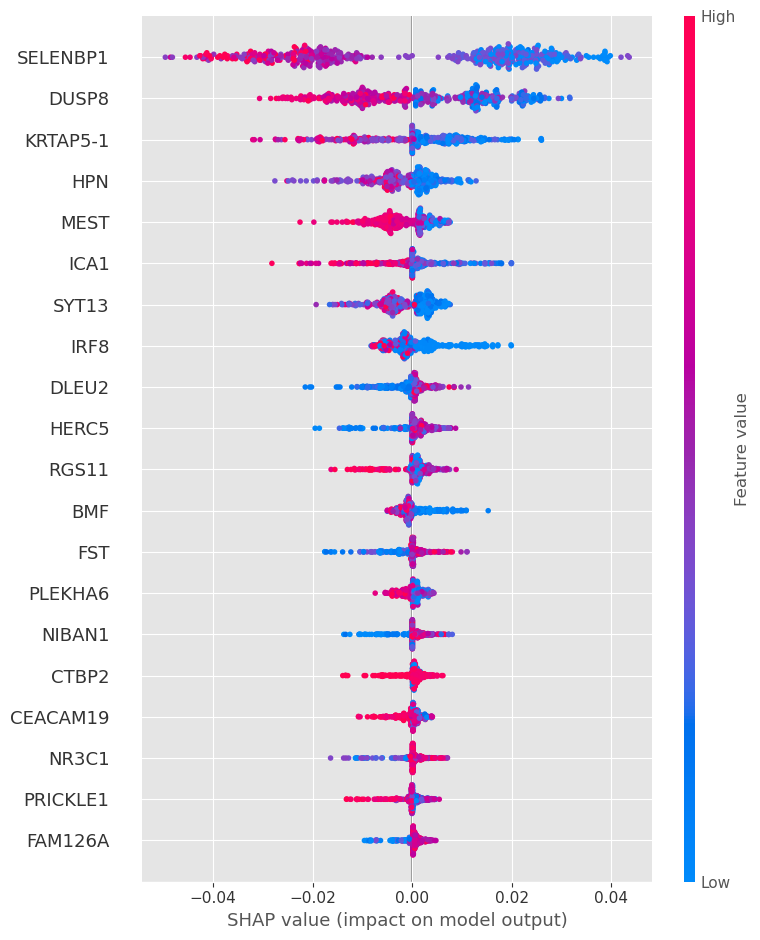

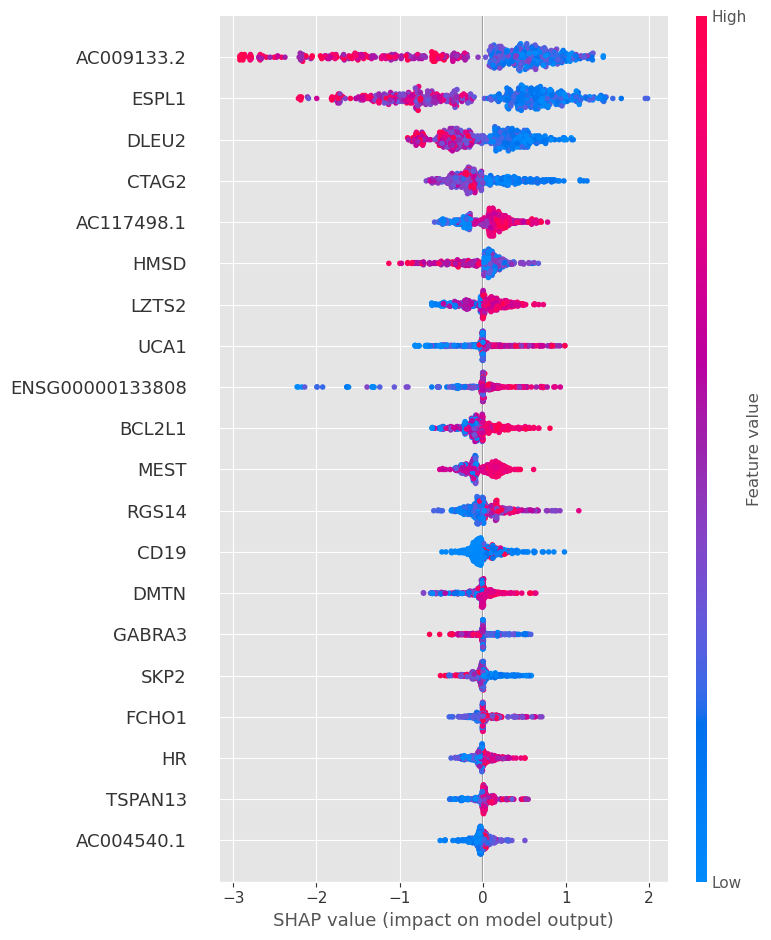

In [ ]:
all_shap0 = np.vstack(all_shap0)
all_shap1 = np.vstack(all_shap1)
all_X = pd.concat(all_X_tests, axis=0)

gene_info = pd.read_csv("../date/Info/gene_info.csv", index_col=0)
mapping_dict = dict(zip(gene_info.index, gene_info["gene_name"]))

feature_names_symbols = [mapping_dict.get(gene_id, gene_id) for gene_id in feature_names]

shap.summary_plot(
    all_shap0,
    all_X,
    feature_names=feature_names_symbols,
    plot_type="dot"
)

shap.summary_plot(
    all_shap1,
    all_X,
    feature_names=feature_names_symbols,
    plot_type="dot"
)

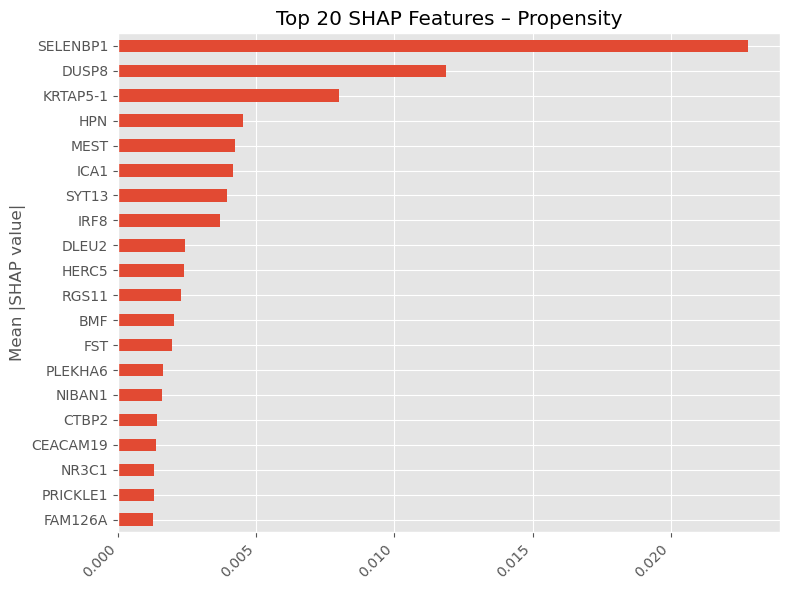

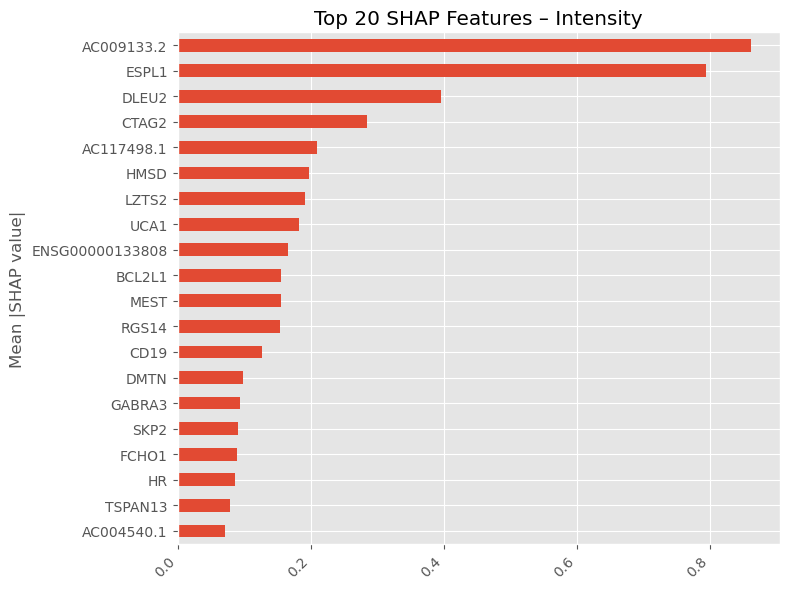

In [78]:
mean_shap0 = np.mean(np.abs(all_shap0), axis=0)  # Propensity
mean_shap1 = np.mean(np.abs(all_shap1), axis=0)  # Intensity

shap_df_propensity = pd.DataFrame(
    mean_shap0,
    index=feature_names_symbols,
    columns=["MeanSHAP_Propensity"]
)

shap_df_intensity = pd.DataFrame(
    mean_shap1,
    index=feature_names_symbols,
    columns=["MeanSHAP_Intensity"]
)

top20_prop = shap_df_propensity.nlargest(20, "MeanSHAP_Propensity")
top20_ints = shap_df_intensity.nlargest(20, "MeanSHAP_Intensity")

plt.figure(figsize=(8, 6))
top20_prop["MeanSHAP_Propensity"].sort_values().plot.barh()
plt.ylabel("Mean |SHAP value|")
plt.title("Top 20 SHAP Features – Propensity")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
top20_ints["MeanSHAP_Intensity"].sort_values().plot.barh()
plt.ylabel("Mean |SHAP value|")
plt.title("Top 20 SHAP Features – Intensity")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
